# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)

## Подготовка данных

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

import warnings
warnings.filterwarnings("ignore")
import time

In [3]:
sns.set(style="whitegrid") 

In [4]:
data = pd.read_csv('/datasets/autos.csv')

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
#Форматирование названий столбцов 
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

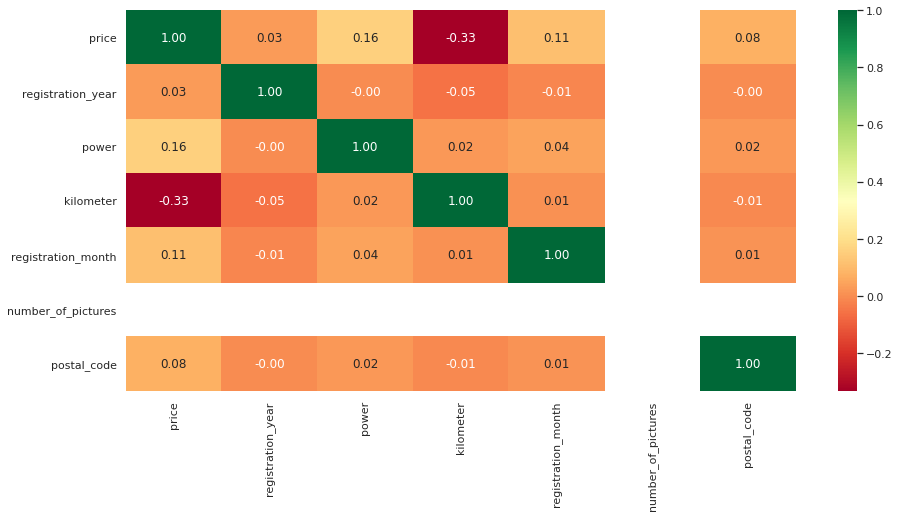

In [8]:
# Корреляция параметров
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='RdYlGn');

Коэффициенты Пирсона менее 0.5, корреляция отсутствует

Построим основные распределения по признакам

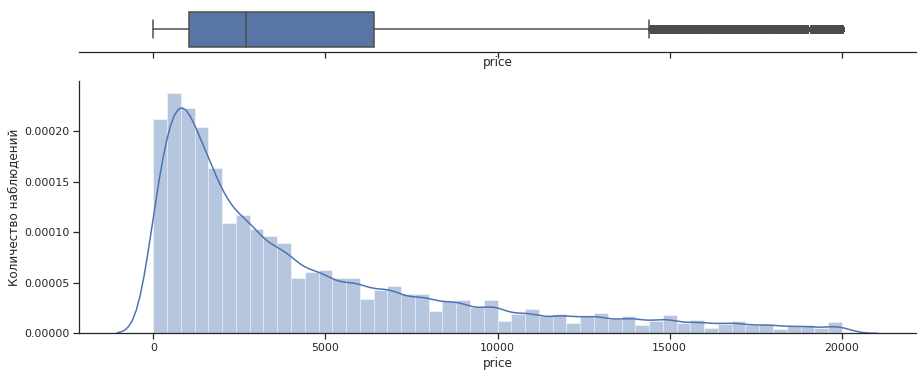

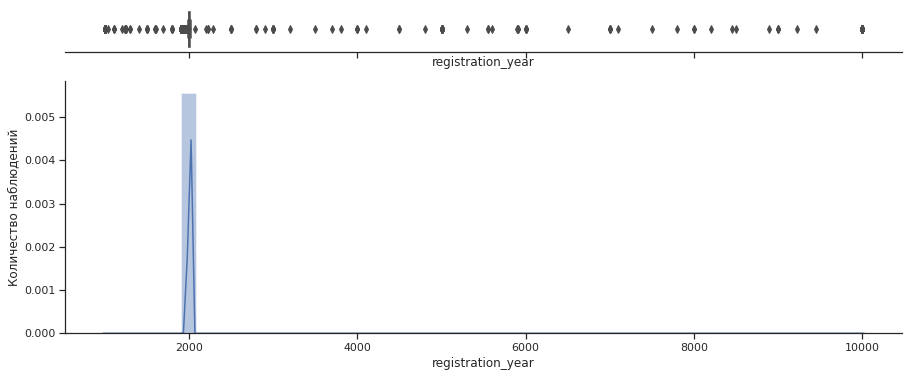

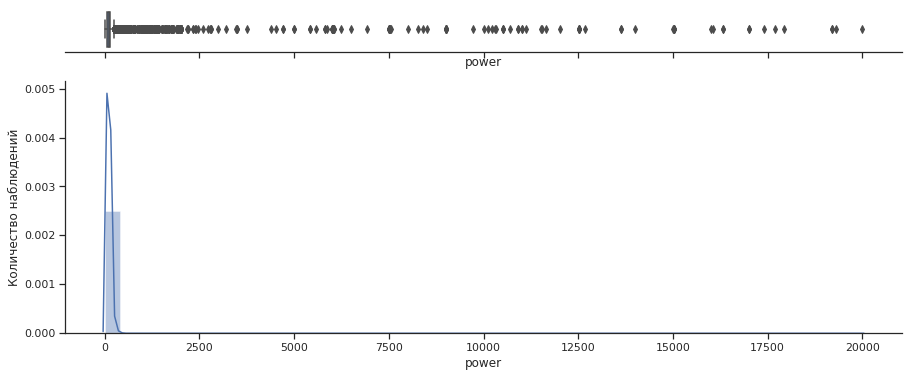

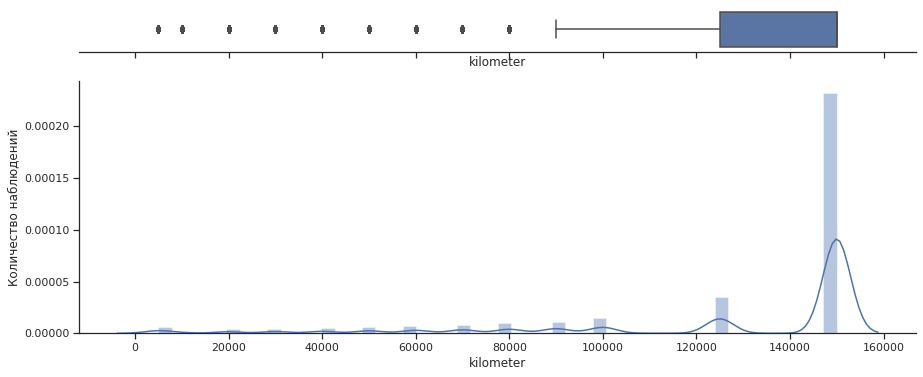

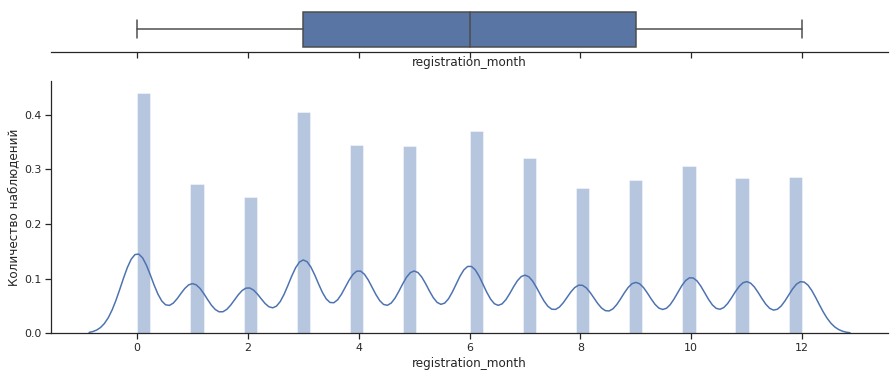

In [9]:
sns.set(style="ticks")

for i in ['price', 'registration_year', 'power', 'kilometer', 'registration_month']:
    
    x = data[i]

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(15,6),
                                    gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.boxplot(x, ax=ax_box)
    sns.distplot(x, ax=ax_hist)

    ax_box.set(yticks=[])
    plt.ylabel('Количество наблюдений')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.show()

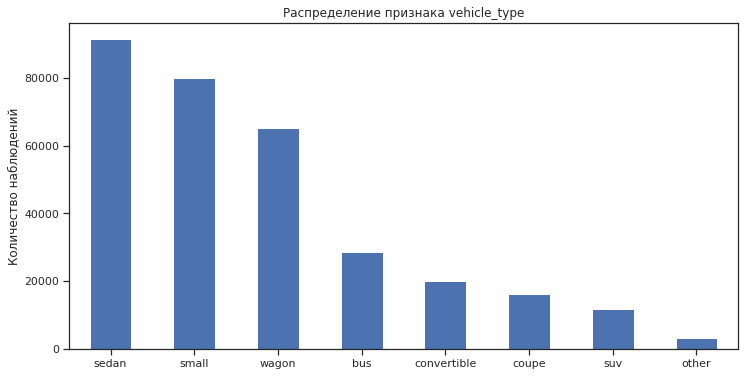

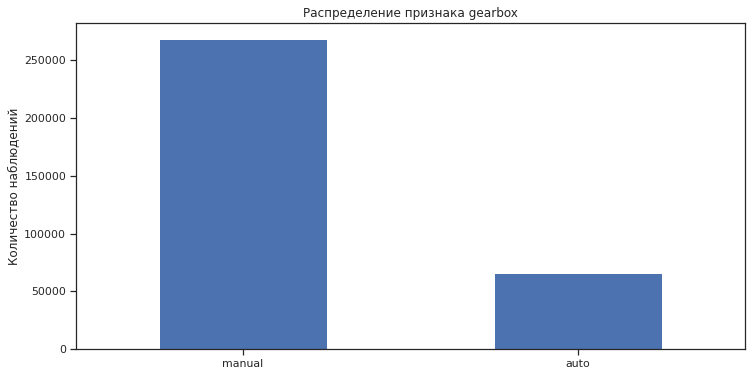

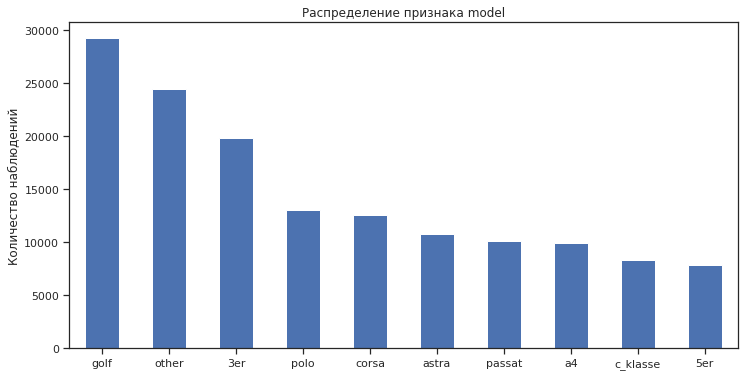

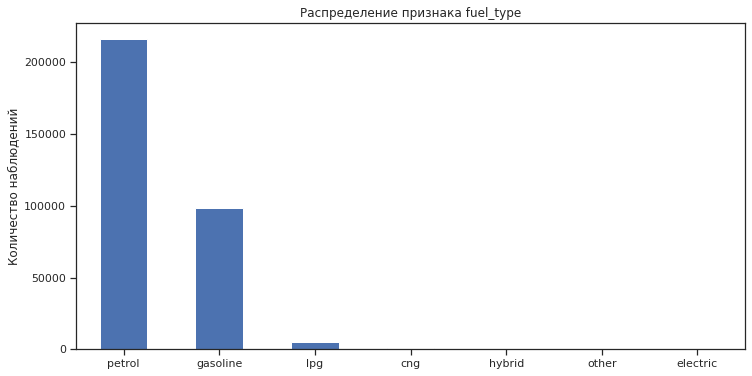

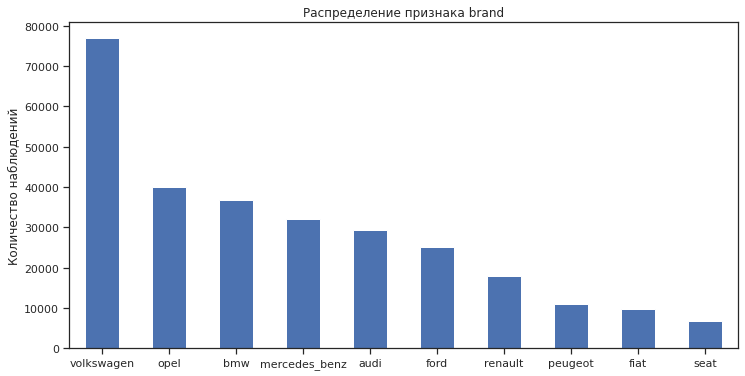

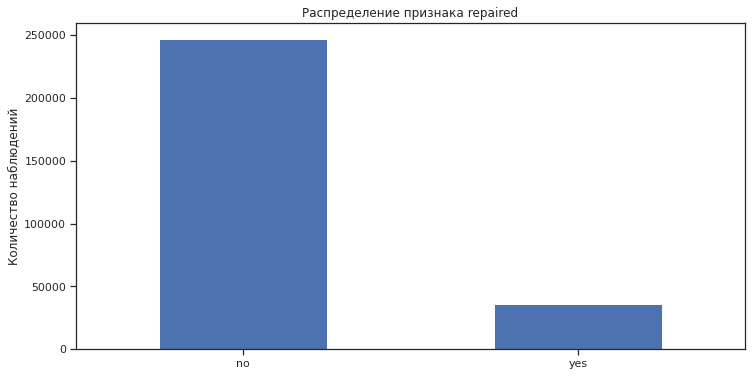

In [11]:
for i in ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']:
    plt.figure(figsize=(12,6))
    data[i].value_counts().head(10).plot(kind ='bar', rot='0')
    plt.ylabel('Количество наблюдений')
    plt.title(f'Распределение признака {i}')
    plt.show()

<div style="border:solid black 3px; padding: 10px">
<b> Выводы:</b>

- Некорректные название столбцов

- Для целого ряда столбцов есть пропущенные значения, по ряду признаков есть аномальные значения.

- Пропуски в типе автомобильного кузова, коробке передач, модели и типе используемого топлива предлагается заполнить по аналогичным данным в датасете.

- Можно предположить, что отсутствующая информация о ремонте автомобиля означает, что автомобиль не ремонтировался.

- Столбцы DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen не имеют значимости и будут удалены.

- Выбросы в признаках будут отброшены с учетом их распределения.

### Предобработка данных

In [12]:
# Количество пропущенных значений
data.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [13]:
# Процент пропусков 
for i in data.columns:
    if data[i].isna().sum()/data[i].count()*100 > 0:
        a = data[i].isna().sum()/data[i].count()
        display(f'Процент пропусков в признаке {i} - {a:.02%}')

'Процент пропусков в признаке vehicle_type - 11.83%'

'Процент пропусков в признаке gearbox - 5.93%'

'Процент пропусков в признаке model - 5.89%'

'Процент пропусков в признаке fuel_type - 10.23%'

'Процент пропусков в признаке repaired - 25.12%'

In [14]:
# Кол-во обьектов до обработки 
start_len = data.shape[0]
start_len

354369

In [15]:
# подсчёт явных дубликатов
data.loc[data.duplicated()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [16]:
# удаление явных дубликатов
data = data.drop_duplicates()

Предположив, что отсутствующая информация о ремонте автомобиля означает, что автомобиль не ремонтировался заполним пропуски значением no.

In [17]:
data['repaired'] = data['repaired'].fillna('no') 

Пропуски в признаке `model` заполним по наиболее часто встречающимся значении в сгруппированной таблице, при отсутствии данных производится замена на значение `other`.

In [18]:
data['model'] = data.groupby(['brand', 'registration_year', 'power'])['model'].transform(
    lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "other")))

Пропуски в признаке `gearbox` заполним по наиболее часто встречающимся значении в сгруппированной таблице.

In [19]:
data['gearbox'] = data.groupby(['brand', 'model', 'registration_year'])['gearbox'].transform(
    lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "unknown")))

Пропуски в признаке `fuel_type` заполним по наиболее часто встречающимся значении в сгруппированной таблице.

In [20]:
data['fuel_type'] = data.groupby(['brand', 'model', 'registration_year', 'gearbox'])['fuel_type'].transform(
    lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "unknown")))

Пропуски в признаке `vehicle_type` заполним по наиболее часто встречающимся значении в сгруппированной таблице.

In [21]:
data['vehicle_type'] = data.groupby(['brand', 'model', 'registration_year'])['vehicle_type'].transform(
    lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "unknown")))

Столбцы `DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen` не представляют интереса для модели, их можно удалить.

In [22]:
# удаление лишних столбцов
data = data.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)

Так как в датасете после заполнения всеравно остались пропуски, то обьекты с пропусками будут удалены.

In [23]:
for i in ['vehicle_type', 'fuel_type', 'gearbox']:
    data[i] = data[i].replace('unknown', np.nan)

In [24]:
data.isna().sum()

price                     0
vehicle_type          14612
registration_year         0
gearbox                 407
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type               655
brand                     0
repaired                  0
dtype: int64

In [25]:
# удаление пропусков
data = data.dropna()

In [26]:
print(f'После удаления пропусков датасет уменьшился на {1-data.shape[0]/start_len:.02%}')

После удаления пропусков датасет уменьшился на 4.20%


Создадим новый столбец, включающий обьединение признаков brand и model

In [27]:
data['brand_model'] = data['brand']+'_'+data['model']

Теперь можно удалить эти два столбца

In [28]:
# удаление лишних столбцов
data = data.drop(['brand', 'model'], axis=1)

In [29]:
# распределение 
for i in range(0, 13):
    print(i, data[data['registration_month'] == i]['registration_month'].count())

0 33311
1 22459
2 20589
3 33233
4 28183
5 28134
6 30383
7 26308
8 21764
9 23064
10 25260
11 23380
12 23418


Признак `registration_month` имеет лишнее значение, так как точно определить его невозможно то его также можно удалить

In [30]:
# удаление лишних столбцов
data = data.drop(['registration_month'], axis=1)

### Обработка аномальных значений

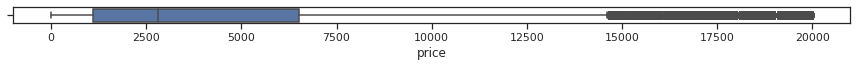

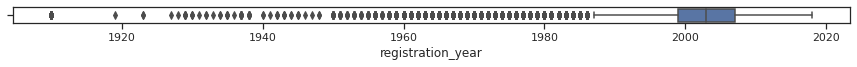

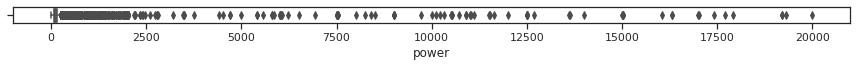

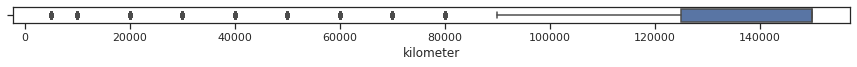

In [31]:
#распределение числовых признаков
for i in ['price','registration_year','power','kilometer']:
    plt.figure(figsize=(15,.3))
    sns.boxplot(data[i]);
    plt.show()

Очистим признак `power` от выбросов и некорректных  данных, т.к. мощность машины меньше 40 лошадиных сил неадекватна, значения нужно заменить на медианное значение по сгруппированной таблице по аналогичным объявлениям. Значения, которые входят в промежуток больше удвоенного значения правого уса, можно удалить.

In [32]:
# Возвращает значение границ
def whiskers(column):
    # межквартирльный размах
    iqr = data[column].describe()[6] - data[column].describe()[4]
    
    # левый и правый "ус"    
    left_whisker = round(data[column].describe()[4] - 1.5 * iqr, 2)
    right_whisker = round(data[column].describe()[6] + 1.5 * iqr, 2)
    
    # левый "ус" не должен быть меньше минимального значения
    if left_whisker < data[column].describe()[3]: left_whisker = data[column].describe()[3] 
        
    # правый "ус" не должен быть больше максимального значения
    if right_whisker > data[column].describe()[7]: right_whisker = data[column].describe()[7]
           
    return [left_whisker, right_whisker]

In [33]:
data = data[data['power'] < whiskers('power')[1]*2]

In [34]:
data['power'] = data['power'].replace(0, np.nan)

In [35]:
data['power'] = data.groupby(['brand_model', 'registration_year', 'vehicle_type', 'gearbox'])['power'].transform(
    lambda x: x.fillna(x.median()))

Очистим целевой признак `price` от выбросов и некорректных  данных, т.к. стоимость машины за 0 евро неадекватна, значения нужно заменить на медианное значение по сгруппированной таблице по аналогичным объявлениям. Значения, которые входят в промежуток больше значения правого уса, можно удалить.

In [36]:
data = data[data['price'] < whiskers('price')[1]]

In [37]:
data['price'] = data['price'].replace(0, np.nan)

In [38]:
data['price'] = data.groupby(['brand_model', 'registration_year', 'vehicle_type', 'gearbox'])['price'].transform(
    lambda x: x.fillna(x.median()))

In [39]:
# Кол-во обьявлений меньше 40 евро
data[data['price'] < 40]['price'].count()

1452

Кол-во относительно общего датасета не велико, их также удаляем.

In [40]:
data = data[data['price'] >= 40].reset_index(drop=True)

В признаке `registration_year` оставим только современные автомобили, раритетные машины сохраним в отдельном датасете.

In [41]:
# удаление пропусков
data = data.dropna()

In [42]:
old_data = data[data['registration_year'] < 1980].reset_index(drop=True)

In [43]:
data = data[(data['registration_year'] >= 1980) & (data['registration_year'] <= 2016)].reset_index(drop=True)

In [44]:
print(f'После удаления пропусков датасет уменьшился на {1-data.shape[0]/start_len:.02%}')

После удаления пропусков датасет уменьшился на 11.74%


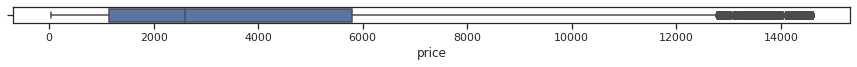

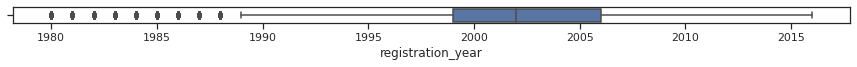

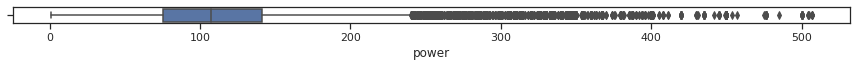

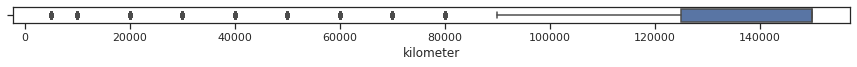

In [45]:
#распределение числовых признаков
for i in ['price','registration_year','power','kilometer']:
    plt.figure(figsize=(15,.3))
    sns.boxplot(data[i]);
    plt.show()

<div style="border:solid black 3px; padding: 10px">
<b> Выводы:</b>

- Название столбцов приведены к нижнему регистру

- Пропущенные значения в количественных признаках заполнены по медиане ближайших аналогов.

- Аномальные значения признаков отброшены с учетом крайних значений усов.

- Пропуски в типе автомобильного кузова, коробке передач, модели и типе используемого топлива заполнены по ближайшим аналогам.

- Отсутствующая информация о ремонте автомобиля означает, что автомобиль не ремонтировался.

- Столбцы DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen и registration_month не имеют значимости и удалены.

- Признаки модель и бренд объединены в один.

## Обучение моделей

### One-Hot Encoding

Преобразуем категориальные признаки в численные техникой прямого кодирования One-Hot Encoding

In [46]:
# кодирование признаков ohe
data_ohe = pd.get_dummies(data, drop_first=True)

In [47]:
features_ohe = data_ohe.drop('price',axis=1)
target_ohe = data_ohe['price']

In [48]:
x_train_ohe, x_test_ohe, y_train_ohe, y_test_ohe = train_test_split(features_ohe, target_ohe,
                                                            test_size=.25, random_state=12345)

### Ordinal Encoder

In [49]:
#Названия признаков
cat_features = ['vehicle_type', 'gearbox', 'brand_model', 'fuel_type', 'repaired']
quantity_features = ['power', 'registration_year', 'kilometer']

In [50]:
features = data.drop('price',axis=1)
target = data['price']

encoder = OrdinalEncoder(categories = 'auto')

features = pd.concat([pd.DataFrame(data = encoder.fit_transform(features[cat_features]),
                                   columns = cat_features), features[quantity_features]], axis=1)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=.25, random_state=12345)

Масштабирование признаков

In [52]:
#Масштабирование признаков выборок
scaler = StandardScaler()
scaler.fit(x_train_ohe[quantity_features])

x_train_ohe[quantity_features] = scaler.transform(x_train_ohe[quantity_features])
x_test_ohe[quantity_features] = scaler.transform(x_test_ohe[quantity_features])

x_train[quantity_features] = scaler.transform(x_train[quantity_features])
x_test[quantity_features] = scaler.transform(x_test[quantity_features])

## Анализ моделей

### Линейная регрессия

In [62]:
%%time
line_Reg = LinearRegression()
cross_val_line = cross_val_score(line_Reg,
                                 features_ohe,
                                 target_ohe,
                                 scoring='neg_mean_squared_error',
                                 n_jobs=-1,
                                 cv=KFold(5, shuffle=True, random_state=12345))

CPU times: user 1min 29s, sys: 1min 12s, total: 2min 41s
Wall time: 2min 45s


In [63]:
%%time
line_Reg.fit(x_train_ohe, y_train_ohe)

CPU times: user 17.9 s, sys: 20.6 s, total: 38.5 s
Wall time: 40.2 s


LinearRegression()

In [64]:
%%time
line_Reg.predict(x_train_ohe)
print(time)

<module 'time' (built-in)>
CPU times: user 217 ms, sys: 229 ms, total: 446 ms
Wall time: 485 ms


In [65]:
print('rmse =', np.mean(np.sqrt(np.abs(cross_val_line)))) 

rmse = 2081.40893329433


### Decision Tree Regressor

In [59]:
%%time
params_dtr_grid = {
    'max_depth' : range(1, 16)
}

grid_model_tree = GridSearchCV(DecisionTreeRegressor(random_state=12345),
                               param_grid = params_dtr_grid,
                               scoring='neg_mean_squared_error',
                               cv=KFold(5, shuffle=True, random_state=12345),
                               n_jobs=-1) 

grid_model_tree.fit(x_train, y_train)

params_tree = grid_model_tree.best_params_

decision_tree = DecisionTreeRegressor(**params_tree, random_state = 12345)

rmse_model_decision_tree = np.mean(np.sqrt(np.abs(grid_model_tree.best_score_)))
print('Параметры модели: ', grid_model_tree.best_params_)
print('rmse =', rmse_model_decision_tree)

Параметры модели:  {'max_depth': 15}
rmse = 1522.6970104761688
CPU times: user 19.5 s, sys: 0 ns, total: 19.5 s
Wall time: 19.5 s


In [60]:
decision_tree_time_fit = grid_model_tree.cv_results_['mean_fit_time'].max()

In [61]:
decision_tree_time_score = grid_model_tree.cv_results_['mean_score_time'].max()

### Random Forest Regressor

In [75]:
%%time
param_rf_grid = {
    'n_estimators' : range(80, 110, 10),
    'max_depth' : range(13, 16)
}

grid_model_forest = GridSearchCV(RandomForestRegressor(random_state=12345),
                                 param_grid = param_rf_grid, 
                                 scoring='neg_mean_squared_error',
                                 cv=KFold(5, shuffle=True, random_state=12345), 
                                 n_jobs=-1) 

grid_model_forest.fit(x_train, y_train)

params_forest = grid_model_forest.best_params_
random_forest = RandomForestRegressor(**params_forest, random_state = 12345)

rmse_model_random_forest = np.mean(np.sqrt(np.abs(grid_model_forest.best_score_)))
print('Параметры модели: ', grid_model_forest.best_params_)
print('rmse =', rmse_model_random_forest)

Параметры модели:  {'max_depth': 15, 'n_estimators': 100}
rmse = 1366.6948085408171
CPU times: user 19min 26s, sys: 5.04 s, total: 19min 31s
Wall time: 19min 35s


In [76]:
random_forest_time_fit = grid_model_forest.cv_results_['mean_fit_time'].max()

In [77]:
random_forest_time_score = grid_model_forest.cv_results_['mean_score_time'].max()

### LightGBM 

In [66]:
%%time
params = {
    'max_depth' : range(10, 17, 3),
    'learning_rate': np.arange(0.1, 0.9, 0.1)}

grid_model_light = GridSearchCV(estimator=LGBMRegressor(random_state = 12345),
                                param_grid=params,
                                verbose=10,
                                scoring='neg_mean_squared_error',
                                cv=KFold(5, shuffle=True, random_state=12345),
                                n_jobs=-1)                            
                                
grid_model_light.fit(x_train, y_train)

params_light = grid_model_light.best_params_
Lightgbm = LGBMRegressor(**params_light, random_state = 12345)

rmse_model_lightgbm = np.mean(np.sqrt(np.abs(grid_model_light.best_score_)))

print('Параметры модели: ', grid_model_light.best_params_)
print('rmse =', rmse_model_lightgbm)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START learning_rate=0.1, max_depth=10............................
[CV 1/5; 1/24] END ..........learning_rate=0.1, max_depth=10; total time= 2.4min
[CV 2/5; 1/24] START learning_rate=0.1, max_depth=10............................
[CV 2/5; 1/24] END ..........learning_rate=0.1, max_depth=10; total time= 1.0min
[CV 3/5; 1/24] START learning_rate=0.1, max_depth=10............................
[CV 3/5; 1/24] END ..........learning_rate=0.1, max_depth=10; total time= 1.6min
[CV 4/5; 1/24] START learning_rate=0.1, max_depth=10............................
[CV 4/5; 1/24] END ..........learning_rate=0.1, max_depth=10; total time=   4.5s
[CV 5/5; 1/24] START learning_rate=0.1, max_depth=10............................
[CV 5/5; 1/24] END ..........learning_rate=0.1, max_depth=10; total time=   3.9s
[CV 1/5; 2/24] START learning_rate=0.1, max_depth=13............................
[CV 1/5; 2/24] END ..........learning_rate=0.1,

In [67]:
LightGBM_time_fit = grid_model_light.cv_results_['mean_fit_time'].max()

In [68]:
LightGBM_time_score = grid_model_light.cv_results_['mean_score_time'].max()

### CatBoostRegressor

In [69]:
features_cat = data.drop('price',axis=1)
target_cat = data['price']

In [70]:
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(features_cat, target_cat,
                                                                    test_size=.25, random_state=12345)

In [71]:
params_cat = {
    'max_depth' : range(10, 17, 3)
}
grid_model_cat = GridSearchCV(estimator=CatBoostRegressor(loss_function='RMSE', iterations=200, random_state = 12345), 
                              param_grid=params_cat,
                              verbose=10,
                              scoring='neg_mean_squared_error',
                              cv=KFold(5, shuffle=True, random_state=12345),
                              n_jobs=-1)

grid_model_cat.fit(x_train_cat, y_train_cat, cat_features=cat_features, verbose=10)

params_cat = grid_model_cat.best_params_

cat = CatBoostRegressor(**params_cat, loss_function='RMSE', iterations=200, random_state = 12345)

rmse_model_cat = np.mean(np.sqrt(np.abs(grid_model_cat.best_score_)))

print('Параметры модели:', grid_model_cat.best_params_)
print('rmse =', rmse_model_cat)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START max_depth=10................................................
Learning rate set to 0.346447
0:	learn: 2741.6061523	total: 357ms	remaining: 1m 11s
10:	learn: 1515.5360222	total: 2.55s	remaining: 43.8s
20:	learn: 1438.6270219	total: 4.4s	remaining: 37.5s
30:	learn: 1397.3281412	total: 6.45s	remaining: 35.2s
40:	learn: 1364.2511841	total: 8.57s	remaining: 33.3s
50:	learn: 1342.8051341	total: 10.8s	remaining: 31.6s
60:	learn: 1327.0661675	total: 13s	remaining: 29.5s
70:	learn: 1310.7581179	total: 15s	remaining: 27.2s
80:	learn: 1300.3850186	total: 16.9s	remaining: 24.8s
90:	learn: 1283.8149534	total: 19s	remaining: 22.8s
100:	learn: 1272.0330443	total: 21.1s	remaining: 20.7s
110:	learn: 1260.5318594	total: 23.3s	remaining: 18.7s
120:	learn: 1251.9919082	total: 25.4s	remaining: 16.6s
130:	learn: 1241.9569059	total: 27.6s	remaining: 14.5s
140:	learn: 1235.5272911	total: 29.9s	remaining: 12.5s
150:	learn: 1228.7946

In [72]:
CatBoost_time_fit = grid_model_cat.cv_results_['mean_fit_time'].max()

In [73]:
CatBoost_time_score = grid_model_cat.cv_results_['mean_score_time'].max()

In [78]:
result = {'Линейная_регрессия':np.array([np.mean(np.sqrt(np.abs(cross_val_line))), 21.4, 0.418]),
          
          'Decision_Tree_Regressor':np.array([rmse_model_decision_tree, decision_tree_time_fit, decision_tree_time_score]),
          
          'Random_Forest_Regressor':np.array([rmse_model_random_forest, random_forest_time_fit, random_forest_time_score]),
          
          'Lightgbm':np.array([rmse_model_lightgbm, LightGBM_time_fit, LightGBM_time_score]),
          
          'Cat_Boost_Regressor':np.array([rmse_model_cat, CatBoost_time_fit, CatBoost_time_score])
         } 

result_df=pd.DataFrame(result, index=['RMSE', 'Fit_Time', 'Score_Time'])

In [79]:
result_df

,Линейная_регрессия,Decision_Tree_Regressor,Random_Forest_Regressor,Lightgbm,Cat_Boost_Regressor
RMSE,2081.408933,1522.697010,1366.694809,1352.496634,1329.219329
Fit_Time,21.400000,0.396272,29.119235,116.069976,356.163939
Score_Time,0.418000,0.011476,0.837756,0.384938,0.434788


## Тестирование лучшей модели

In [82]:
cat.fit(x_train_cat, y_train_cat, cat_features=cat_features, verbose=50)
predict_cat = cat.predict(x_test_cat)
rmse = mean_squared_error(y_test_cat, predict_cat, squared=False)
print('rmse =', rmse)

Learning rate set to 0.358879
0:	learn: 2664.2355480	total: 724ms	remaining: 2m 24s
50:	learn: 1250.6478365	total: 27.5s	remaining: 1m 20s
100:	learn: 1172.2073323	total: 57s	remaining: 55.9s
150:	learn: 1125.6104115	total: 1m 25s	remaining: 27.8s
199:	learn: 1091.1802433	total: 1m 54s	remaining: 0us
rmse = 1328.1231845318994


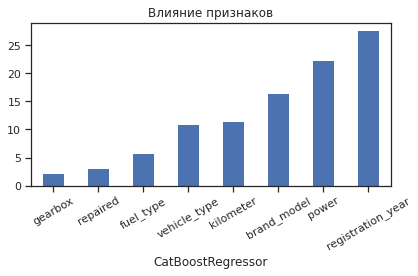

In [81]:
importance = cat.feature_importances_
feature_list = x_train_cat.columns.to_list()
feature_results = pd.Series(importance, index= feature_list).sort_values()

fig, ax = plt.subplots()
feature_results.plot.bar(rot=30)
ax.set_title("Влияние признаков")
ax.set_xlabel("CatBoostRegressor")
fig.tight_layout()

Качество предсказаний классических моделей замето ниже, градиентный бустинг справляется с этой задачей лучше. Поиск гиперпараметров занимает гораздо больше времени, чем обучение линейной регрессии и дерева решений.


Наиболее важные признаки - `power`, `registration_year`, `brand_model`.

<div style="border:solid black 3px; padding: 10px">
<b> Выводы:</b>
    
- Наибольшую точность по метрике RMSE показала модель - <b>CatBoostRegressor</b>, ее и нужно рекомендовать заказчику для внедрения.
    
Модель <b>CatBoostRegressor</b>:
- лучшие параметры были достигнуты при: 'max_depth': 13, 'learning_rate': 0.35, RMSE составило 1328 время обучения 348 c, время предсказания: 0,4 с